# Load candidates

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/anhphantq/otto')

In [2]:
CACHE = '/home/anhphantq/vdb/cache_train'
import os

import pickle
from tqdm import tqdm
import numpy as np
train_data = np.empty((100000000, 67), dtype = np.float64)
# train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = min(metadata['num_frags'], 1000)

offset = 0
for i in tqdm(range(num_frags)):
    with open(CACHE + f'/train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      num_cands.extend(data[1])
      for d in data[0]:
        try:
          train_data[offset: d.shape[0] + offset] = d 
        except:
          print(d.shape[0], d.shape, offset)
          assert False
        offset += d.shape[0]






100%|██████████| 270/270 [00:19<00:00, 13.80it/s]


In [3]:
train_data = train_data[:offset]

In [4]:
import numpy as np
# train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((39501303, 67), (13167101,))

In [5]:
from xgb_utils import *

In [6]:
import pandas as pd 

candidates = create_data(train_data, infer = False)


In [7]:
print(candidates.head())


         user         item  type  cofitness_cosub  cofitness_time_decay  \
0  11367120.0  101293905.0   0.0        42.172377             23.334317   
1  11367120.0  100321666.0   0.0        20.441863             11.344793   
2  11367120.0  101088939.0   0.0        15.311603              8.503005   
3  11367120.0  101576470.0   0.0        11.144227              5.802452   
4  11367120.0  101531805.0   0.0        10.746319              4.729568   

   num_appearance  num_cosub  coclick  cocart  coorder  ...  cocart_var  \
0             9.0       45.0     65.0     5.0      0.0  ...      9.8576   
1             5.0       25.0     40.0     5.0      0.0  ...      9.8576   
2             5.0       25.0     35.0     0.0      0.0  ...      9.8576   
3             5.0       20.0     35.0     5.0      0.0  ...      9.8576   
4             7.0       15.0     38.0     5.0      0.0  ...      9.8576   

   coorder_mean  coorder_var  num_sub  consistency  num_actions       user_pr  \
0          0.64  

# Train params

In [8]:
PARAMS = {
    'max_depth' : 5,
    'eta': 1,
    'min_child_weight': 100,
    'num_parallel_tree': 1,
    # 'colsample_bytree' : 0.5,
    # 'colsample_bynode' : 0.5,
    # 'colsample_bylevel' : 0.5,
    # 'subsample': 0.5,
    # 'scale_pos_weight': 5,
    'objective':'rank:pairwise',
}
N_SPLITS = 3
NUM_TREE = 100
MODEL_PATH = '/home/anhphantq/xgboost'
VERSION = '4'

# Train for each type

In [9]:
from xgb_utils import get_len_group

In [10]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1
tar['item'] = tar['item'] + 100000000

In [11]:
tar

,user,type,item,label
113400,11188590,0,100607328,1
113401,11188591,0,100557157,1
113402,11188591,1,101597320,1
113402,11188591,1,101236555,1
113402,11188591,1,100970284,1
...,...,...,...,...
448302,11458773,0,101372721,1
448303,11458774,0,100167699,1
448304,11458775,0,100885450,1
448305,11458776,0,100364710,1


In [12]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
def train(tar_, candidates_, num_cands_, t, id_type):
  
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove all version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  idx = candidates_['type'] == id_type
  candidates = candidates_[idx].copy()
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)
  
   
  # neg_idx = np.argwhere(candidates['label'].values== 0).flatten() 

  # neg_idx = np.random.permutation(neg_idx)[: int(len(neg_idx) * 0.4)]
  # candidates = candidates.drop(neg_idx)
  # num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
  # num_cands['num_cands'] = num_cands['item']
  # del num_cands['item'] 
  # candidates = candidates.merge(num_cands,on=['user'],how='left')
  # num_cands = candidates['num_cands'].values
  # del candidates['num_cands']
  
  
  del candidates['type'], candidates['user_type']
  
 

  skf = GroupKFold(n_splits=N_SPLITS)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]
      
      # weight = np.where(y_train.values > 0, 5, 1)
      # weight1 = np.where(y_valid.values > 0, 5, 1)

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count()) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count()) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = { 'nthread' : os.cpu_count()
      , **PARAMS}

      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          early_stopping_rounds= 3,    
          verbose_eval=1)
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model)

[0]	train-map:0.81923	valid-map:0.82148
[1]	train-map:0.81996	valid-map:0.82199
[2]	train-map:0.82043	valid-map:0.82253
[3]	train-map:0.82077	valid-map:0.82273
[4]	train-map:0.82102	valid-map:0.82289
[5]	train-map:0.82154	valid-map:0.82322
[6]	train-map:0.82192	valid-map:0.82345
[7]	train-map:0.82213	valid-map:0.82367
[8]	train-map:0.82235	valid-map:0.82374
[9]	train-map:0.82257	valid-map:0.82398
[10]	train-map:0.82295	valid-map:0.82414
[11]	train-map:0.82303	valid-map:0.82405
[12]	train-map:0.82308	valid-map:0.82406
[13]	train-map:0.82314	valid-map:0.82413
[0]	train-map:0.81983	valid-map:0.82038
[1]	train-map:0.82038	valid-map:0.82075
[2]	train-map:0.82090	valid-map:0.82124
[3]	train-map:0.82132	valid-map:0.82157
[4]	train-map:0.82171	valid-map:0.82187
[5]	train-map:0.82224	valid-map:0.82230
[6]	train-map:0.82254	valid-map:0.82244
[7]	train-map:0.82268	valid-map:0.82248
[8]	train-map:0.82279	valid-map:0.82257
[9]	train-map:0.82296	valid-map:0.82255
[10]	train-map:0.82315	valid-map:0.8

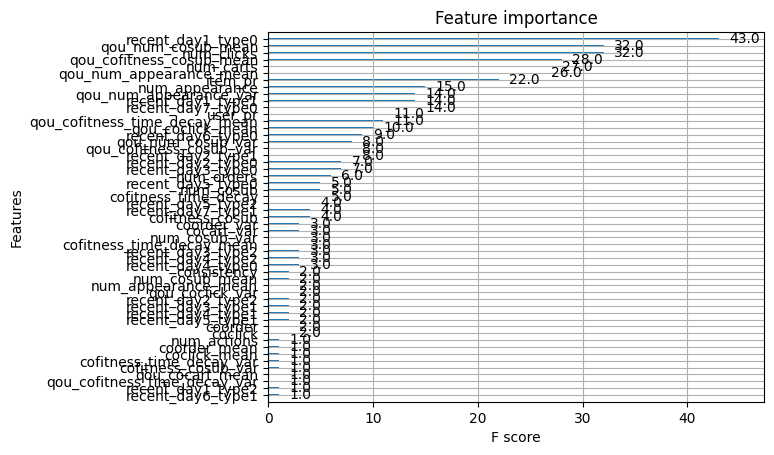

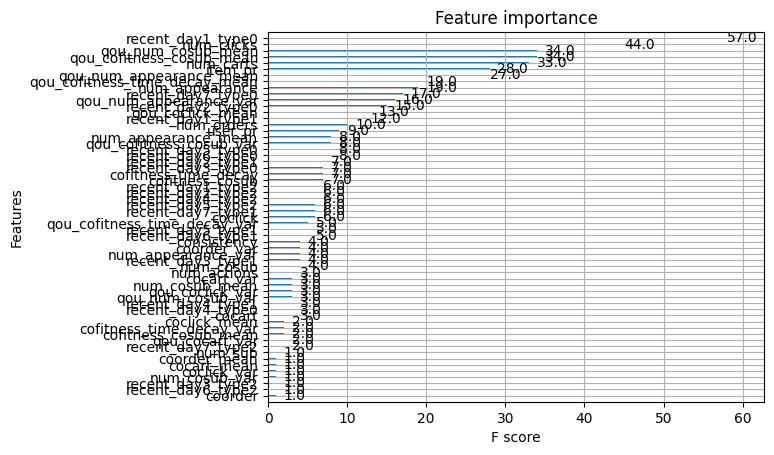

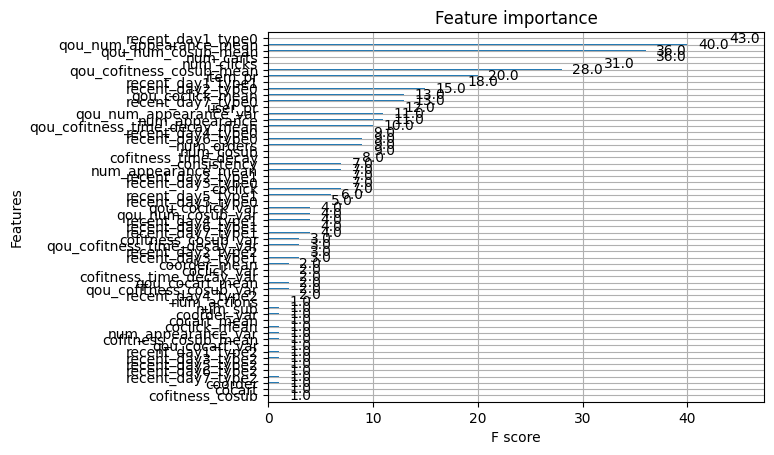

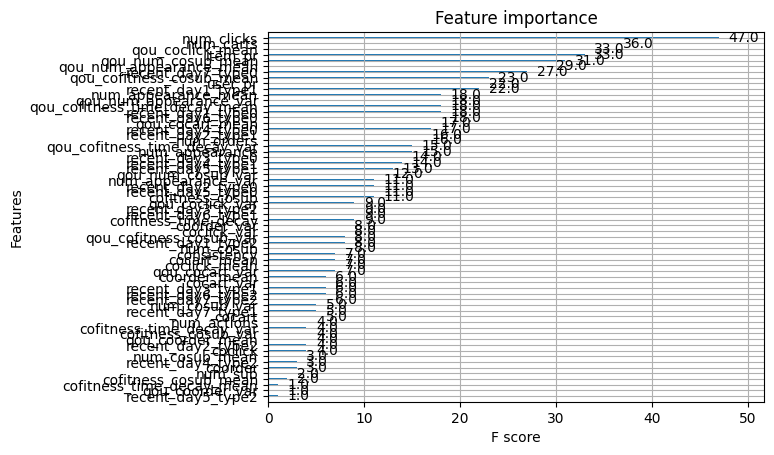

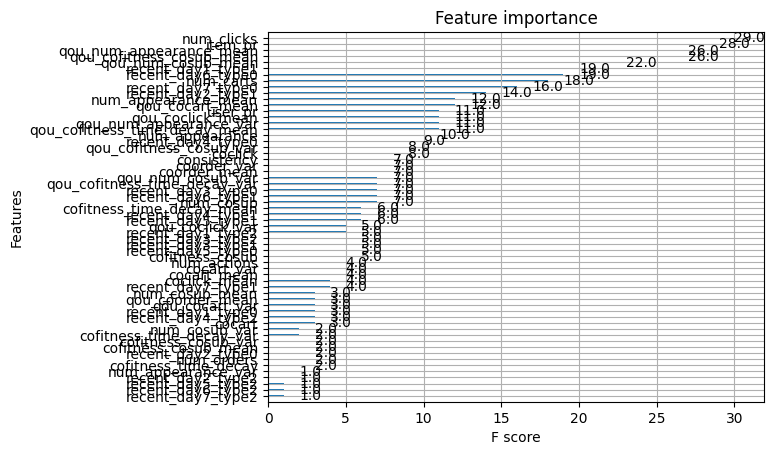

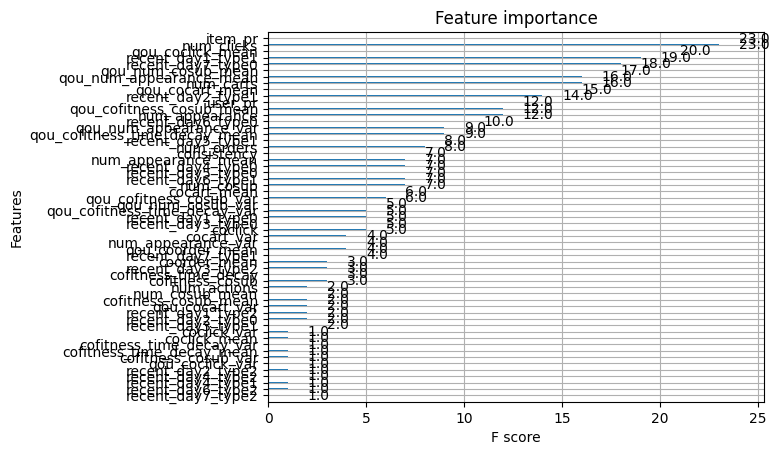

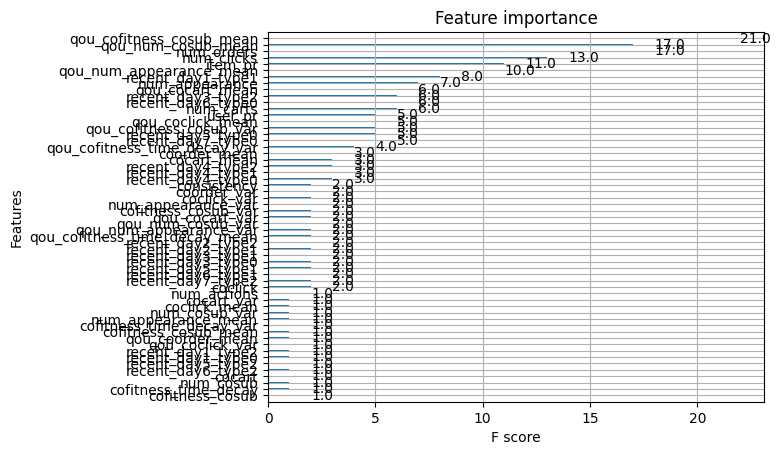

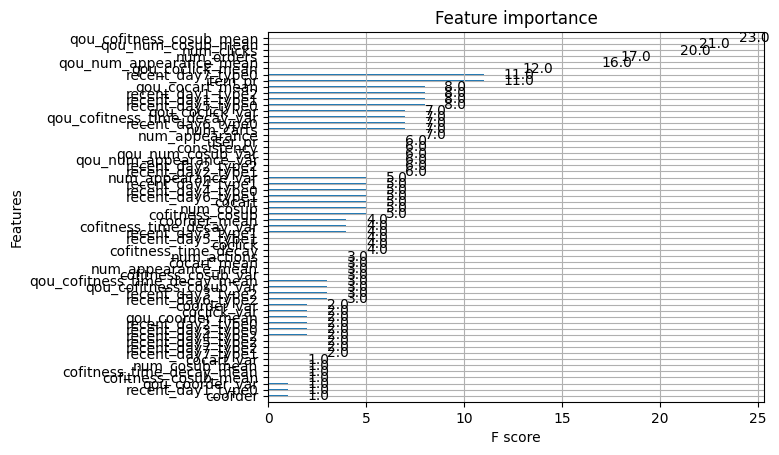

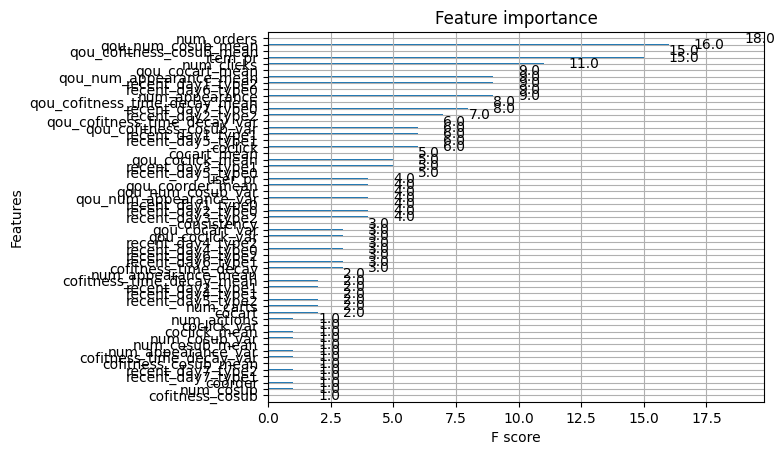

In [13]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, num_cands, t, id_type)